In [107]:
# Imports and Setup
import numpy as np
import os, csv
import matplotlib.pyplot as plt
import librosa
import IPython.display

from bisect import bisect_right, bisect_left
# has to be set in order to show the image in notebook
%matplotlib inline 

try:
    os.chdir("./Resources")
except:
    pass

In [148]:
y, sr = librosa.load('./fire-starts-to-burn.wav', duration=24.00)
IPython.display.Audio(data=y, rate=sr)

(0.0, 1035.0, 0.0, 25.09435558972897)

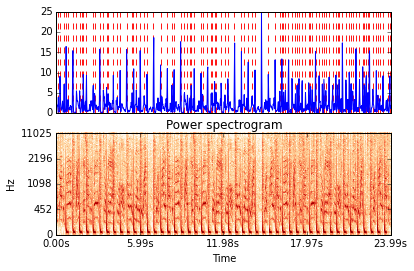

In [149]:
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

o_env = librosa.onset.onset_strength(y, sr=sr)

# Convert to log scale (dB). We'll use the peak power as reference.
log_S = librosa.logamplitude(S, ref_power=np.max)

onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
onset_times  = librosa.frames_to_time(onset_frames[:], sr=sr)

D = np.abs(librosa.stft(y))**2
plt.figure()

plt.subplot(2,1,2)
librosa.display.specshow(librosa.logamplitude(D, ref_power=np.max), x_axis='time', y_axis='log')
plt.title('Power spectrogram')

plt.subplot(2,1,1)
plt.plot(o_env, label='Onset strength')
plt.vlines(onset_frames, 0, o_env.max(), color='r', alpha=0.9, linestyle='--', label='Onsets')
plt.xticks([])
plt.axis('tight')

In [161]:
def snap(times):
    first = times[0]
    qtz = lambda curr: curr - first
    return map(qtz, times)

def beat_range(bpm, length):
    cursor = 0
    times  = [] 
    step   = 60.00 / bpm

    while cursor < length:
        times.append(cursor)
        cursor += step
    
    return times

def find_le(a, x):
    'Find rightmost value less than or equal to x'
    i = bisect_right(a, x)
    if i:
        return a[i-1]
    raise ValueError
    
def find_gt(a, x):
    'Find leftmost value greater than x'
    i = bisect_right(a, x)
    if i != len(a):
        return a[i]
    raise ValueError
    
def closest(a, x):
    less = find_le(a, x)
    more = float("inf")
    try:
        more = find_gt(a, x)
    except:
        print "Couldnt get bigger"

    return min(less, more)

def cross_correlation(times):
    delta = lambda x, y: abs(y - x) 
    bpm_distances = []
    
    for bpm in range(50, 161):
        timeEnd  = times[len(times) - 1]
        distance = 0
        beats    = beat_range(bpm, timeEnd)
        
        for beat in beats:
            distance += delta(find_le(times, beat), beat)

        delta_beats = float(distance / len(beats))
        bpm_distances.append((bpm, delta_beats))
        
    return bpm_distances

def split(results):
    bpms    = []
    deltas  = []
    for element in results:
        bpms.append(element[0])
        deltas.append(element[1])
        
    return bpms, deltas

In [165]:
data = cross_correlation(snap(onset_times))
sorted_by_second = sorted(data, key=lambda tup: tup[1])
print "Guess: %0.2f beats per minute." % (sorted_by_second[0][0]),
print "LibRosa guessed: %0.2f beats per minute" % (librosa.beat.estimate_tempo(o_env))

Guess: 123.00 beats per minute. LibRosa guessed: 123.05 beats per minute


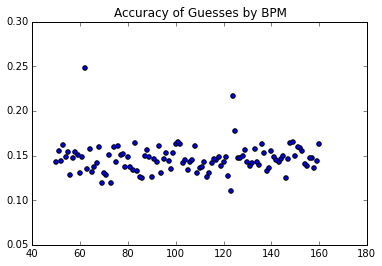

In [169]:
x, y = split(sorted_by_second)
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_title("Accuracy of Guesses by BPM")
ax.s

In [172]:
area = np.pi * (15 * np.random.rand(10))**2
print area

[  5.56937334e+01   2.79785149e+02   2.30591181e+02   2.13670084e+02
   2.55981129e+01   2.18844260e-01   7.52322247e-01   5.90428319e+02
   1.40363581e+02   1.20327155e+00]
